## LSTM(Long Short Term Memory) Model for Time Series Mortgage Rate Prediction

This notebook aims to develop LSTM model to predict future values for Mortgate Rate. Several models were created and evaluated to choose th best one

In [1]:
## Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

#tensorflow Import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error


pd.set_option('display.max_rows', None)

In [2]:
from  google.colab import files
uploaded = files.upload()

Saving fred_mortg_data_clean.csv to fred_mortg_data_clean (7).csv


In [3]:
# Load the data
df = pd.read_csv('fred_mortg_data_clean.csv', parse_dates=['DATE'], index_col='DATE')

# Display the first few rows of the data
print(df.tail())


            MORTGAGE30US  FEDFUNDS  GS10  MICH  UNRATE  USREC  CSUSHPISA  \
DATE                                                                       
2024-02-29          6.94      5.33  4.21   3.0     3.9      0    317.194   
2024-03-07          6.88      5.33  4.21   2.9     3.8      0    318.144   
2024-03-14          6.74      5.33  4.21   2.9     3.8      0    318.144   
2024-03-21          6.87      5.33  4.21   2.9     3.8      0    318.144   
2024-03-28          6.79      5.33  4.21   2.9     3.8      0    318.144   

            MSACSR      GDP  
DATE                         
2024-02-29     8.9  67702.0  
2024-03-07     8.5  67702.0  
2024-03-14     8.5  67702.0  
2024-03-21     8.5  67702.0  
2024-03-28     8.5  67702.0  


In [4]:
mortgage_rt = df['MORTGAGE30US']

In [7]:
len(df)

1944

In [5]:
##Split data into training and test sets
train_size = int(len(mortgage_rt) * 0.8)
train, test = mortgage_rt[:train_size], mortgage_rt[train_size:]

In [9]:
train.shape, test.shape

((1555,), (389,))

In [10]:
test.index[0]

Timestamp('2016-10-20 00:00:00')

In [11]:
train.tail()

DATE
2016-09-15    3.50
2016-09-22    3.48
2016-09-29    3.42
2016-10-06    3.42
2016-10-13    3.47
Name: MORTGAGE30US, dtype: float64

In [12]:
test.head()

DATE
2016-10-20    3.52
2016-10-27    3.47
2016-11-03    3.54
2016-11-10    3.57
2016-11-17    3.94
Name: MORTGAGE30US, dtype: float64

In [6]:
## initialize the MinMaxScaler to scale the data to the range(0,1)

sc = MinMaxScaler()

## reshape the train data into a 2D array and fit and trasform
train_sc = sc.fit_transform(train.values.reshape(-1, 1))

#reshape and transform the test data
test_sc = sc.transform(test.values.reshape(-1, 1))

In [7]:
train_sc.shape

(1555, 1)

In [8]:
test_sc.shape

(389, 1)

#### The TimeseriesGenerator is used to generating batches of temporal data for trainin and validation from give time series dataset. In Deep Learning models like LSTM it is recommended to use TimeseriesGenerator

In [9]:
# define input sequence and features use
n_input = 32
n_features = 1
train_generator = TimeseriesGenerator(train_sc, train_sc, length=n_input, batch_size=32)
test_generator = TimeseriesGenerator(test_sc, test_sc, length=n_input, batch_size=32)

In [17]:
train_generator.length

32

#### LSTM Model1 With 1 Input layer 2 LSMT hidden layers and 1 dense output layer

In [18]:
#Build the LSTM Model -Model1

model1 = Sequential()
model1.add(LSTM(128,activation='relu', input_shape=(n_input, n_features), return_sequences=True))#model.add(BatchNormalization())
model1.add(LSTM(64,activation='relu', return_sequences=False))

#output layer

model1.add(Dense(1))

## Compile
model1.compile(optimizer='adam', loss='mse')

In [19]:
# Train the model
history1 = model1.fit(train_generator, epochs=200, validation_data=test_generator, verbose=0)

In [20]:
# Model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116033 (453.25 KB)
Trainable params: 116033 (453.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


When using the timeseries generator the first n_input data points are used to create the initial sequence because of which the generator can only yield the prediction for the  remaining points. Here my test data had 389 points and my n_input was 32 so generator could only produce 389-32 = 357 sequences thus resulting into 357 predictions thus for calculating RMSE I had to take out first 32 observation from my test data

In [34]:
# # RMSE and predictions
test_pred1 = model1.predict(test_generator)
train_pred1 = model1.predict(train_generator)

test_pred1 = sc.inverse_transform(test_pred1)
train_pred1 = sc.inverse_transform(train_pred1)

##
rmse_test = np.sqrt(mean_squared_error(test[n_input:], test_pred1))

print(f'Model1 Test RMSE: {rmse_test:.4f}')


48/48 [==============================] - 1s 18ms/step
Model1 Test RMSE: 0.1294


In [22]:
test_actual = test[32:].values.reshape(-1, 1)

In [23]:
combine_test_pred = np.concatenate((test_actual, test_pred1), axis=1)

In [24]:
df_test_pred = pd.DataFrame(combine_test_pred, columns=['Actual', 'Predicted'])

In [25]:
df_test_pred.head(10)

,Actual,Predicted
0,3.94,3.950887
1,3.89,3.926200
2,3.91,3.885427
3,3.90,3.889660
4,3.88,3.886711
5,3.96,3.870618
6,4.03,3.926748
7,3.96,3.999379
8,3.92,3.964000
9,3.93,3.916235


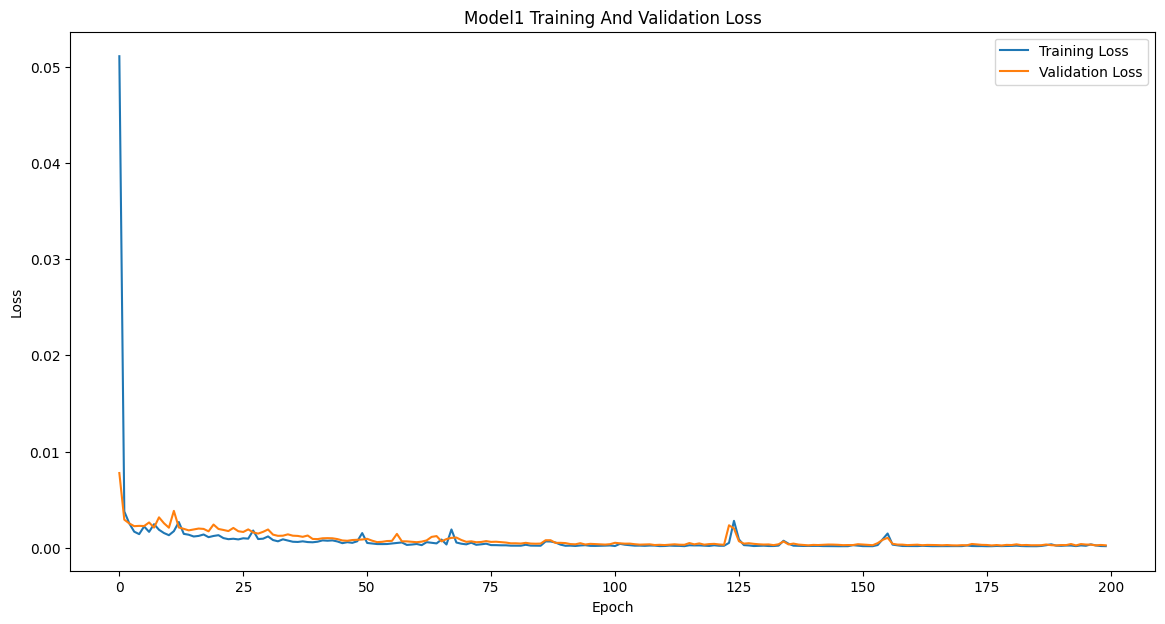

In [26]:
# Plot the loss function
plt.figure(figsize=(14, 7))
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title(f'Model1 Training And Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Model2 LSTM2 Added one more layer  layer `model2.add(LSTM(56,activation='relu', return_sequences=False))`

---



In [10]:
#Model2 LSTM2 Added one more layer  layer


model2 = Sequential()
model2.add(LSTM(128,activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model2.add(LSTM(64,activation='relu', return_sequences=True))
## New layer added
model2.add(LSTM(56,activation='relu', return_sequences=False))
#output layer

model2.add(Dense(1))

## Compile
model2.compile(optimizer='adam', loss='mse')

In [11]:
# Train the model
history2 = model2.fit(train_generator, epochs=200, validation_data=test_generator, verbose=0)

In [12]:
# Model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 32, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 56)                27104     
                                                                 
 dense (Dense)               (None, 1)                 57        
                                                                 
Total params: 143129 (559.10 KB)
Trainable params: 143129 (559.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# # RMSE and predictions
test_pred2 = model2.predict(test_generator)
train_pred2 = model2.predict(train_generator)

test_pred2 = sc.inverse_transform(test_pred2)
train_pred2 = sc.inverse_transform(train_pred2)

##
rmse_test2 = np.sqrt(mean_squared_error(test[n_input:], test_pred2))

print(f'Model2 Test RMSE: {rmse_test2:.4f}')


48/48 [==============================] - 1s 22ms/step
Model2 Test RMSE: 0.1347


In [14]:
test_actual = test[32:].values.reshape(-1, 1)
combine_test_pred2 = np.concatenate((test_actual, test_pred2), axis=1)
df_test_pred2 = pd.DataFrame(combine_test_pred2, columns=['Actual', 'Predicted'])
df_test_pred2.head(10)

,Actual,Predicted
0,3.94,3.929908
1,3.89,3.897284
2,3.91,3.859295
3,3.90,3.847763
4,3.88,3.842421
5,3.96,3.830149
6,4.03,3.860186
7,3.96,3.918245
8,3.92,3.917141
9,3.93,3.885704


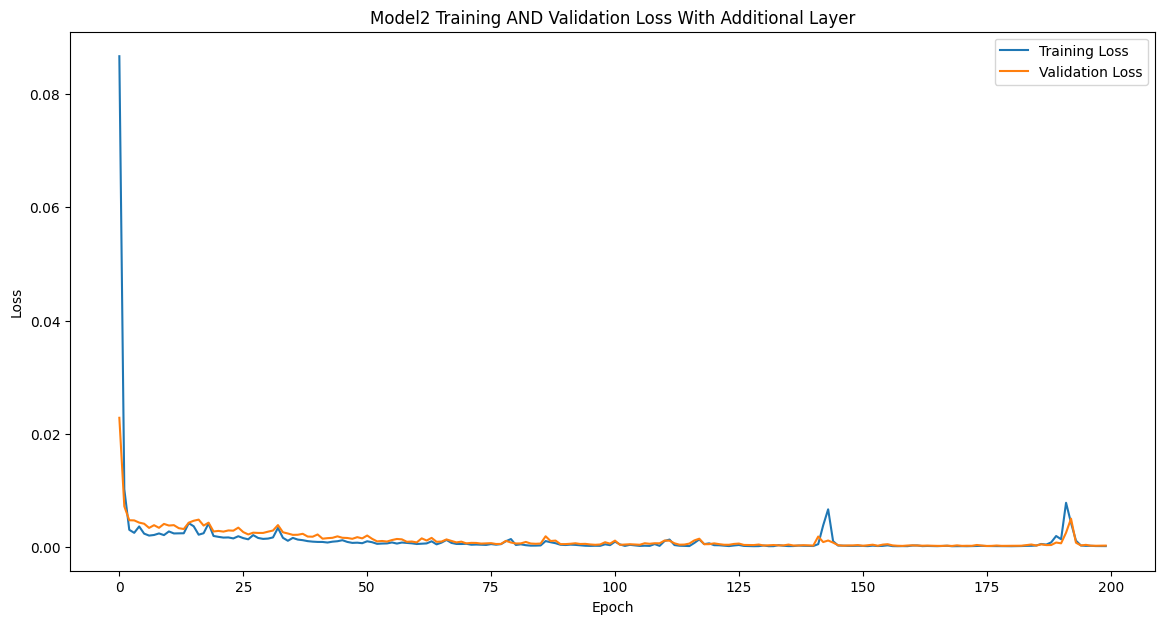

In [15]:
# Plot the loss function
plt.figure(figsize=(14, 7))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title(f'Model2 Training AND Validation Loss With Additional Layer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### LSTM Model3 Added batch normalization and early stopping

In [47]:
#LSTM Model3 Added batch normalization and early stopping

model3 = Sequential()
model3.add(LSTM(128,activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model3.add(BatchNormalization())
model3.add(LSTM(64,activation='relu', return_sequences=True))
model3.add(LSTM(56,activation='relu', return_sequences=False))

#output layer

model3.add(Dense(1))

## Compile
model3.compile(optimizer='adam', loss='mse')

In [48]:
# Model summary
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 32, 128)           66560     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 128)           512       
 chNormalization)                                                
                                                                 
 lstm_13 (LSTM)              (None, 32, 64)            49408     
                                                                 
 lstm_14 (LSTM)              (None, 56)                27104     
                                                                 
 dense_3 (Dense)             (None, 1)                 57        
                                                                 
Total params: 143641 (561.10 KB)
Trainable params: 143385 (560.10 KB)
Non-trainable params: 256 (1.00 KB)
______________

In [49]:
# Train the model

es = EarlyStopping(patience = 5, monitor = 'val_loss')
history3 = model3.fit(train_generator, epochs=300,callbacks=[es],validation_data=test_generator, verbose=0)

In [50]:
# # RMSE and predictions
test_pred3 = model3.predict(test_generator)
train_pred3 = model3.predict(train_generator)

test_pred3 = sc.inverse_transform(test_pred3)
train_pred3 = sc.inverse_transform(train_pred3)

##
rmse_test3 = np.sqrt(mean_squared_error(test[n_input:], test_pred3))

print(f'Model3 Test RMSE: {rmse_test3:.2f}')


48/48 [==============================] - 1s 25ms/step
Model3 Test RMSE: 1.45


In [70]:
combine_test_pred3 = np.concatenate((test_actual, test_pred3), axis=1)
df_test_pred3 = pd.DataFrame(combine_test_pred3, columns=['Actual', 'Predicted'])
df_test_pred3.head(10)

,Actual,Predicted
0,3.94,5.063112
1,3.89,5.061145
2,3.91,5.058509
3,3.90,5.054939
4,3.88,5.050710
5,3.96,5.046859
6,4.03,5.043485
7,3.96,5.040812
8,3.92,5.038672
9,3.93,5.036708


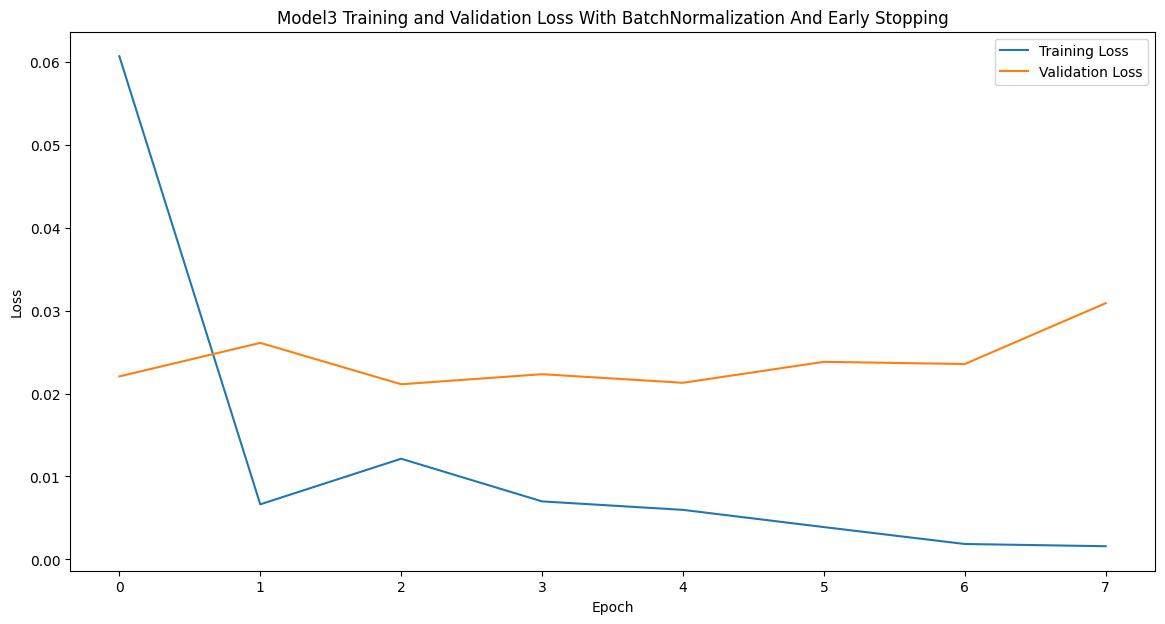

In [67]:
# Plot the loss function
plt.figure(figsize=(14, 7))
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title(f'Model3 Training and Validation Loss With BatchNormalization And Early Stopping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Adding BatchNormalization with early stopping did not helpp the model performance. Loss function was increased and RMSE also high 1.45

In [54]:
#LSTM4 Removed Batch Normalization but kept early stopping

model4 = Sequential()
model4.add(LSTM(128,activation='relu', input_shape=(n_input, n_features), return_sequences=True))

model4.add(LSTM(64,activation='relu', return_sequences=True))
model4.add(LSTM(56,activation='relu', return_sequences=False))

#output layer

model4.add(Dense(1))

## Compile
model4.compile(optimizer='adam', loss='mse')

In [55]:
# Model summary
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 32, 128)           66560     
                                                                 
 lstm_16 (LSTM)              (None, 32, 64)            49408     
                                                                 
 lstm_17 (LSTM)              (None, 56)                27104     
                                                                 
 dense_4 (Dense)             (None, 1)                 57        
                                                                 
Total params: 143129 (559.10 KB)
Trainable params: 143129 (559.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
# Train the model
es = EarlyStopping(patience = 5, monitor = 'val_loss')
history4 = model4.fit(train_generator, epochs=200,callbacks=[es],validation_data=test_generator, verbose=0)


In [57]:
# # RMSE and predictions
test_pred4 = model4.predict(test_generator)
train_pred4 = model4.predict(train_generator)

test_pred4 = sc.inverse_transform(test_pred4)
train_pred4 = sc.inverse_transform(train_pred4)

##
rmse_test4 = np.sqrt(mean_squared_error(test[n_input:], test_pred4))

print(f'Model4 Test RMSE: {rmse_test4:.2f}')

48/48 [==============================] - 1s 23ms/step
Model4 Test RMSE: 0.48


In [ ]:
# # Visualize loss
train_loss_model4 = history4.history['loss']
test_loss_model4 = history4.history['val_loss']

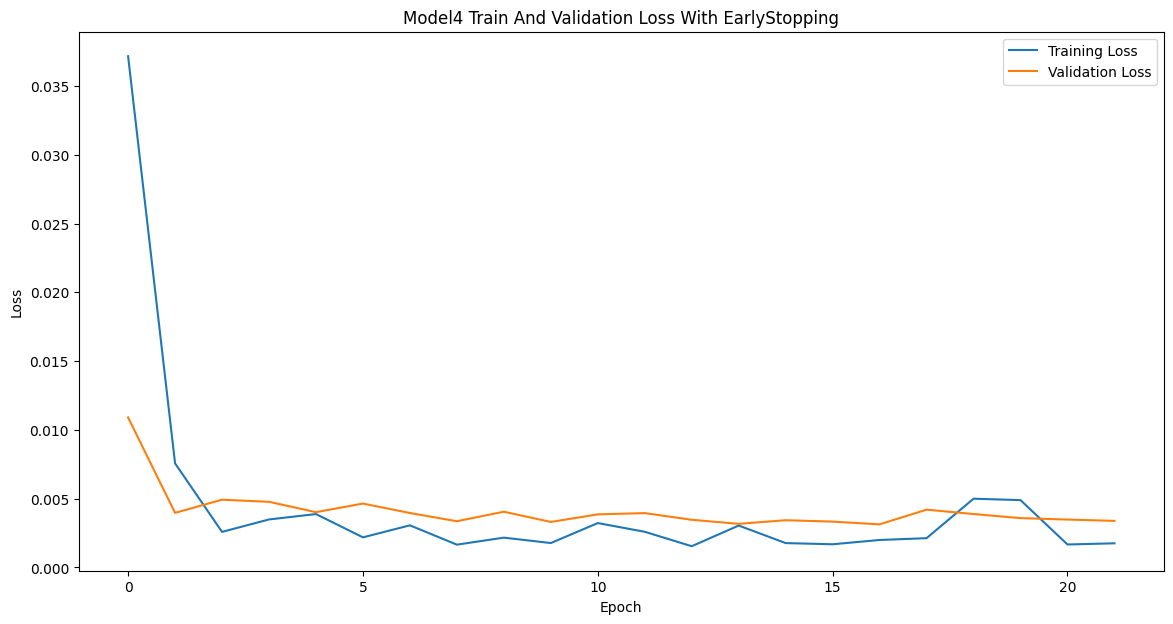

In [66]:
# Plot the loss function
plt.figure(figsize=(14, 7))
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title(f'Model4 Train And Validation Loss With EarlyStopping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### LSTM Model5 Added 20% Drop out

In [59]:
#LSTM5 Model5 Added 20% drop out

model5 = Sequential()
model5.add(LSTM(128,activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model5.add(LSTM(64,activation='relu', return_sequences=True))
model5.add(LSTM(56,activation='relu', return_sequences=False))

model5.add(Dropout(0.2))


#output layer

model5.add(Dense(1))

## Compile
model5.compile(optimizer='adam', loss='mse')

In [60]:
# Model summary
model5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 32, 128)           66560     
                                                                 
 lstm_19 (LSTM)              (None, 32, 64)            49408     
                                                                 
 lstm_20 (LSTM)              (None, 56)                27104     
                                                                 
 dropout (Dropout)           (None, 56)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 57        
                                                                 
Total params: 143129 (559.10 KB)
Trainable params: 143129 (559.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
# Train the model

history5 = model5.fit(train_generator, epochs=150, validation_data=test_generator, verbose=0)

In [62]:
# # RMSE and predictions
test_pred5 = model5.predict(test_generator)
train_pred5 = model5.predict(train_generator)

test_pred5 = sc.inverse_transform(test_pred5)
train_pred5 = sc.inverse_transform(train_pred5)

##
rmse_test5 = np.sqrt(mean_squared_error(test[n_input:], test_pred5))

print(f'Model5 Test RMSE: {rmse_test5:.2f}')


48/48 [==============================] - 1s 23ms/step
Model5 Test RMSE: 0.20


In [63]:
combine_test_pred5 = np.concatenate((test_actual, test_pred5), axis=1)
df_test_pred5 = pd.DataFrame(combine_test_pred5, columns=['Actual', 'Predicted'])
df_test_pred5.head(10)

,Actual,Predicted
0,3.94,3.887332
1,3.89,3.859832
2,3.91,3.825183
3,3.90,3.801813
4,3.88,3.788176
5,3.96,3.776643
6,4.03,3.790800
7,3.96,3.835588
8,3.92,3.854783
9,3.93,3.844228


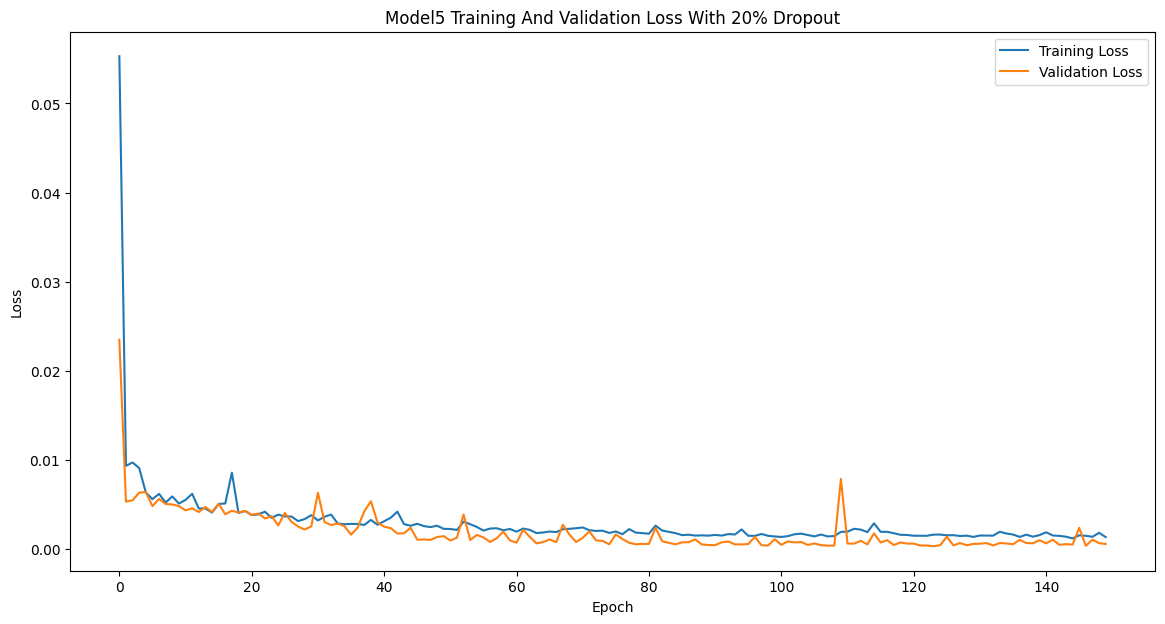

In [65]:
# Plot the loss function
plt.figure(figsize=(14, 7))
plt.plot(history5.history['loss'], label='Training Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.title(f'Model5 Training And Validation Loss With 20% Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### After hypertuning and evaluating all the models above we can conclude that Model1 and Model 2 are the best performing model of which Model1 ( Model1 With 1 Input layer 2 LSMT hidden layers and 1 dense output layer ) outperformed the Model with it's least test RMSE of 0.1294 and smaller validation loss